In [8]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

In [2]:
telecom_data = pd.read_csv('./HW3_data.csv', header=None)
telecom_data = pd.DataFrame(telecom_data.values.reshape(telecom_data.shape[1], 2), columns=['x', 'y'])
telecom_data.head()

,x,y
0,17.218862,20.838999
1,11.968430,80.804795
2,83.848662,67.629543
3,70.819127,69.846960
4,79.570422,82.935346


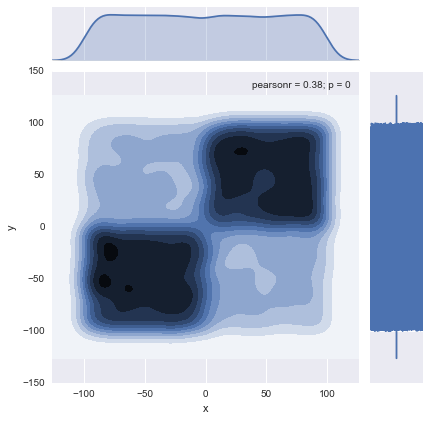

In [6]:
sns.jointplot(telecom_data['x'], telecom_data['y'], kind="kde")

In [13]:
### define loss function and derivatives

f = lambda ((x, y, (l1, l2))): (0.000045*(l2**2)*y 
                            - 0.000098*(l1**2)*x 
                            + 0.003926*l1*x*np.exp((y**2 - x**2)*(l1**2 + l2**2)))
fprime_l1 = lambda (x, y, l1, l2): (-2*(0.000098)*l1*x 
                                    + 0.003926*x*np.exp((y**2 - x**2)*(l1**2 + l2**2)) 
                                    + 0.003926*l1*x*np.exp((y**2 - x**2)*(l1**2 + l2**2))*((y**2 - x**2))*2*l1)
fprime_l2 = lambda (x, y, l1, l2): (2*(0.000045)*l2*y 
                                    + 0.003926*l1*x*np.exp((y**2 - x**2)*(l1**2 + l2**2))*((y**2 - x**2))*2*l2)

In [20]:
l1s = np.linspace(2.05384 - 0.05 , 2.05384 + 0.05, 40)
l2s = np.linspace(-0.05 , 0.05, 40)

L1, L2 = np.meshgrid(l1s, l2s)

def loss (x, y, l1, l2):
    return np.sum(f(((x, y, (l1, l2)))))
zs = np.array([loss(telecom_data['x'], telecom_data['y'], l1, l2) 
               for (l1, l2) in zip(np.ravel(L1), np.ravel(L2))])
print zs.shape

(1600,)


In [18]:
L2.shape

(40, 40)

In [ ]:
Z = zs.reshape(L1.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(L1, L2, Z, rstride=1, cstride=1, color='b', alpha=0.2)
ax.contour(L1, L2, Z, 20, color='b', alpha=0.5, offset=0, stride=30)

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.


### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.


### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.